In [1]:
import pandas as pd

In [2]:
df=pd.read_csv(r"C:\Users\HP\Desktop\merged_Sub_saharan_processed.csv")

In [3]:
df.columns

Index(['ur', 'age', 'marital_status', 'religion', 'num_HH_members', 'radio',
       'tv', 'school', 'pregnant', 'heard_implants', 'heard_IUD',
       'current_method', 'fp_side_effects', 'fp_ever_used', 'age_at_first_use',
       'visited_by_health_worker', 'visited_a_facility', 'fp_ad_radio',
       'fp_ad_tv', 'fp_ad_magazine', 'age_at_first_use_children',
       'age_at_first_sex', 'wealthquintile', 'long_acting_user'],
      dtype='object')

In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.combine import SMOTEENN

# Load dataset
df=pd.read_csv(r"C:\Users\HP\Desktop\merged_Sub_saharan_processed.csv")

# Target variable
target = 'long_acting_user'

# Convert binary columns to 0/1
binary_cols = ['radio', 'tv', 'school', 'pregnant', 'heard_implants', 'heard_IUD',
               'fp_side_effects', 'fp_ever_used', 'visited_by_health_worker',
               'visited_a_facility', 'fp_ad_radio', 'fp_ad_tv', 'fp_ad_magazine']
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].map({'Yes': 1, 'No': 0})

# Map wealth quintile to ordinal
if 'wealthquintile' in df.columns:
    wealth_map = {
        'Lowest quintile': 1,
        'Second quintile': 2,
        'Middle quintile': 3,
        'Fourth quintile': 4,
        'Highest quintile': 5
    }
    df['wealthquintile'] = df['wealthquintile'].map(wealth_map)

# Convert numeric columns
numeric_cols = ['age', 'num_HH_members', 'age_at_first_use',
                'age_at_first_use_children', 'age_at_first_sex']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Encode 'current_method' if present
if 'current_method' in df.columns:
    df['current_method'] = df['current_method'].astype('category').cat.codes

# Create interaction terms
if 'age' in df.columns and 'num_HH_members' in df.columns:
    df['age_household'] = df['age'] * df['num_HH_members']
if 'school' in df.columns and 'radio' in df.columns and 'tv' in df.columns:
    df['education_media'] = df['school'] * (df['radio'] + df['tv'])

# Drop columns with all missing values
df = df.dropna(axis=1, how='all')

# Drop rows with missing target
df = df.dropna(subset=[target])

# Define feature list
top_features = [
    'age', 'num_HH_members', 'fp_ever_used', 'heard_implants', 'fp_side_effects',
    'visited_by_health_worker', 'visited_a_facility', 'fp_ad_radio', 'fp_ad_tv',
    'fp_ad_magazine', 'age_at_first_use', 'age_at_first_use_children',
    'wealthquintile', 'age_household', 'education_media'
]

# Filter only existing columns
available_features = [f for f in top_features if f in df.columns]

# Prepare data
X = df[available_features]
y = df[target]

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Apply SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_imputed, y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "LightGBM": LGBMClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "SVM": SVC(probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier(),
    "Naïve Bayes": GaussianNB(),
    "MLP": MLPClassifier(max_iter=500),
    "KNN": KNeighborsClassifier()
}

# Train and evaluate models
results = []
for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

    results.append({
        "Model": name,
        "AUC-ROC": round(roc_auc_score(y_test, y_proba), 3),
        "Accuracy": round(accuracy_score(y_test, y_pred), 3),
        "Precision": round(precision_score(y_test, y_pred, zero_division=0), 3),
        "Recall": round(recall_score(y_test, y_pred), 3),
        "F1 Score": round(f1_score(y_test, y_pred), 3)
    })

# Display results
results_df = pd.DataFrame(results)
print("Model Performance Summary:")
print(results_df.sort_values(by="AUC-ROC", ascending=False).to_string(index=False))


[LightGBM] [Info] Number of positive: 10666, number of negative: 8750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3075
[LightGBM] [Info] Number of data points in the train set: 19416, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549341 -> initscore=0.198007
[LightGBM] [Info] Start training from score 0.198007


C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [15:49:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model Performance Summary:
              Model  AUC-ROC  Accuracy  Precision  Recall  F1 Score
      Random Forest    0.997     0.982      0.997   0.971     0.984
           LightGBM    0.995     0.982      0.997   0.970     0.983
            XGBoost    0.995     0.982      0.996   0.972     0.984
                MLP    0.992     0.952      0.963   0.948     0.956
           AdaBoost    0.987     0.952      0.968   0.943     0.956
                KNN    0.984     0.943      0.910   0.994     0.950
                SVM    0.977     0.917      0.939   0.907     0.923
        Naïve Bayes    0.811     0.584      0.570   0.984     0.722
Logistic Regression    0.797     0.740      0.734   0.826     0.777


[LightGBM] [Info] Number of positive: 10666, number of negative: 8750
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3075
[LightGBM] [Info] Number of data points in the train set: 19416, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549341 -> initscore=0.198007
[LightGBM] [Info] Start training from score 0.198007


C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [15:51:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


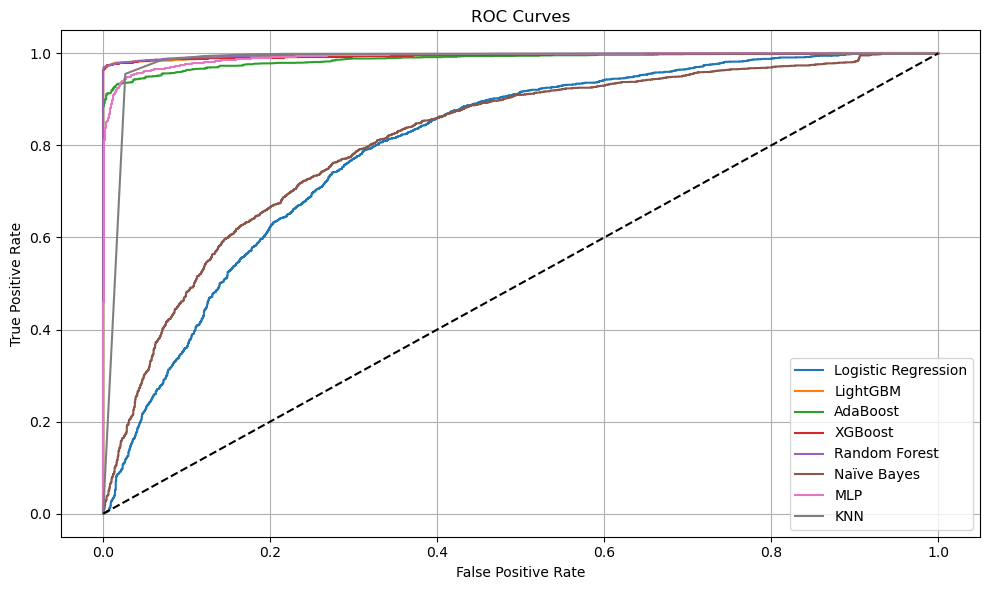

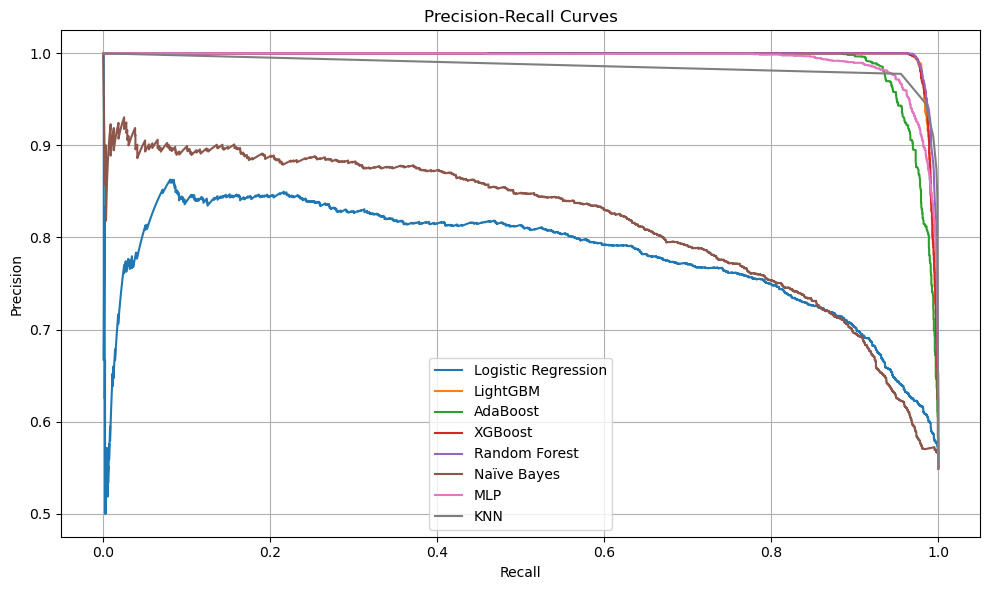


Best Model: Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2188
           1       1.00      0.97      0.98      2666

    accuracy                           0.98      4854
   macro avg       0.98      0.98      0.98      4854
weighted avg       0.98      0.98      0.98      4854



In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.combine import SMOTEENN

# Load dataset
df=pd.read_csv(r"C:\Users\HP\Desktop\merged_Sub_saharan_processed.csv")
# Target variable
target = 'long_acting_user'

# Binary and numeric conversions
binary_cols = ['radio', 'tv', 'school', 'pregnant', 'heard_implants', 'heard_IUD',
               'fp_side_effects', 'fp_ever_used', 'visited_by_health_worker',
               'visited_a_facility', 'fp_ad_radio', 'fp_ad_tv', 'fp_ad_magazine']
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].map({'Yes': 1, 'No': 0})

wealth_map = {
    'Lowest quintile': 1, 'Second quintile': 2, 'Middle quintile': 3,
    'Fourth quintile': 4, 'Highest quintile': 5
}
if 'wealthquintile' in df.columns:
    df['wealthquintile'] = df['wealthquintile'].map(wealth_map)

numeric_cols = ['age', 'num_HH_members', 'age_at_first_use',
                'age_at_first_use_children', 'age_at_first_sex']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

if 'current_method' in df.columns:
    df['current_method'] = df['current_method'].astype('category').cat.codes

# Interaction terms
if 'age' in df.columns and 'num_HH_members' in df.columns:
    df['age_household'] = df['age'] * df['num_HH_members']
if 'school' in df.columns and 'radio' in df.columns and 'tv' in df.columns:
    df['education_media'] = df['school'] * (df['radio'] + df['tv'])

# Drop columns with all missing values
df = df.dropna(axis=1, how='all')
df = df.dropna(subset=[target])

# Feature list
top_features = [
    'age', 'num_HH_members', 'fp_ever_used', 'heard_implants', 'fp_side_effects',
    'visited_by_health_worker', 'visited_a_facility', 'fp_ad_radio', 'fp_ad_tv',
    'fp_ad_magazine', 'age_at_first_use', 'age_at_first_use_children',
    'wealthquintile', 'age_household', 'education_media'
]
features = [f for f in top_features if f in df.columns]

# Prepare data
X = df[features]
y = df[target]
X = pd.DataFrame(SimpleImputer(strategy='median').fit_transform(X), columns=features)

# Resample
X_resampled, y_resampled = SMOTEENN(random_state=42).fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "LightGBM": LGBMClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier(),
    "Naïve Bayes": GaussianNB(),
    "MLP": MLPClassifier(max_iter=500),
    "KNN": KNeighborsClassifier()
}

# Evaluation
results = []
roc_data = {}
pr_data = {}

for name, model in models.items():
    pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe.named_steps['clf'], 'predict_proba') else y_pred

    auc = roc_auc_score(y_test, y_proba)
    results.append({
        "Model": name,
        "AUC-ROC": round(auc, 3),
        "Accuracy": round(accuracy_score(y_test, y_pred), 3),
        "Precision": round(precision_score(y_test, y_pred, zero_division=0), 3),
        "Recall": round(recall_score(y_test, y_pred), 3),
        "F1 Score": round(f1_score(y_test, y_pred), 3)
    })

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    roc_data[name] = (fpr, tpr)
    pr_data[name] = (rec, prec)

# Plot ROC
plt.figure(figsize=(10, 6))
for name, (fpr, tpr) in roc_data.items():
    plt.plot(fpr, tpr, label=name)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Precision-Recall
plt.figure(figsize=(10, 6))
for name, (rec, prec) in pr_data.items():
    plt.plot(rec, prec, label=name)
plt.title("Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Best model report
best_model = max(results, key=lambda x: x["AUC-ROC"])["Model"]
print(f"\nBest Model: {best_model}")
model = models[best_model]
pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.combine import SMOTEENN
from scipy.stats import norm

# --- DeLong implementation ---
def compute_midrank(x):
    """Computes midranks."""
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5 * (i + j - 1) + 1
        i = j
    T2 = np.empty(N, dtype=float)
    T2[J] = T
    return T2

def fastDeLong(predictions_sorted_transposed, label_1_count):
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]

    k = predictions_sorted_transposed.shape[0]
    tx = np.zeros((k, m))
    ty = np.zeros((k, n))
    tz = np.zeros((k, m + n))

    for r in range(k):
        tx[r] = compute_midrank(positive_examples[r])
        ty[r] = compute_midrank(negative_examples[r])
        tz[r] = compute_midrank(predictions_sorted_transposed[r])

    aucs = (tz[:, :m].mean(axis=1) - (m + 1) / 2.0) / n
    v01 = (tz[:, :m] - tx) / m
    v10 = (tz[:, m:] - ty) / n

    sx = np.atleast_2d(np.cov(v01))
    sy = np.atleast_2d(np.cov(v10))
    delongcov = sx / m + sy / n
    return aucs, delongcov

def delong_roc_variance(y_true, y_scores):
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    order = np.argsort(-y_scores)
    y_true = y_true[order]
    y_scores = y_scores[order]
    pos_count = np.sum(y_true)
    predictions_sorted_transposed = y_scores[np.newaxis, :]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, int(pos_count))
    return aucs[0], np.sqrt(delongcov[0, 0])


def auc_ci(y_true, y_scores, alpha=0.95):
    auc, auc_std = delong_roc_variance(y_true, y_scores)
    lower_upper_q = norm.ppf([(1 - alpha) / 2, (1 + alpha) / 2])
    ci = auc + lower_upper_q * auc_std
    ci[ci > 1] = 1
    ci[ci < 0] = 0
    return auc, tuple(ci)

# --- Load dataset ---
df = pd.read_csv(r"C:\Users\HP\Desktop\merged_Sub_saharan_processed.csv")
target = 'long_acting_user'

binary_cols = ['radio', 'tv', 'school', 'pregnant', 'heard_implants', 'heard_IUD',
               'fp_side_effects', 'fp_ever_used', 'visited_by_health_worker',
               'visited_a_facility', 'fp_ad_radio', 'fp_ad_tv', 'fp_ad_magazine']
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].map({'Yes': 1, 'No': 0})

wealth_map = {
    'Lowest quintile': 1, 'Second quintile': 2, 'Middle quintile': 3,
    'Fourth quintile': 4, 'Highest quintile': 5
}
if 'wealthquintile' in df.columns:
    df['wealthquintile'] = df['wealthquintile'].map(wealth_map)

numeric_cols = ['age', 'num_HH_members', 'age_at_first_use',
                'age_at_first_use_children', 'age_at_first_sex']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

if 'current_method' in df.columns:
    df['current_method'] = df['current_method'].astype('category').cat.codes

if 'age' in df.columns and 'num_HH_members' in df.columns:
    df['age_household'] = df['age'] * df['num_HH_members']
if 'school' in df.columns and 'radio' in df.columns and 'tv' in df.columns:
    df['education_media'] = df['school'] * (df['radio'] + df['tv'])

df = df.dropna(axis=1, how='all')
df = df.dropna(subset=[target])

top_features = [
    'age', 'num_HH_members', 'fp_ever_used', 'heard_implants', 'fp_side_effects',
    'visited_by_health_worker', 'visited_a_facility', 'fp_ad_radio', 'fp_ad_tv',
    'fp_ad_magazine', 'age_at_first_use', 'age_at_first_use_children',
    'wealthquintile', 'age_household', 'education_media'
]
features = [f for f in top_features if f in df.columns]

X = df[features]
y = df[target]
X = pd.DataFrame(SimpleImputer(strategy='median').fit_transform(X), columns=features)

X_resampled, y_resampled = SMOTEENN(random_state=42).fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "LightGBM": LGBMClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier(),
    "Naïve Bayes": GaussianNB(),
    "MLP": MLPClassifier(max_iter=500),
    "KNN": KNeighborsClassifier()
}

results = []
roc_data = {}
pr_data = {}

for name, model in models.items():
    pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe.named_steps['clf'], 'predict_proba') else y_pred

    auc = roc_auc_score(y_test, y_proba)
    results.append({
        "Model": name,
        "AUC-ROC": round(auc, 3),
        "Accuracy": round(accuracy_score(y_test, y_pred), 3),
        "Precision": round(precision_score(y_test, y_pred, zero_division=0), 3),
        "Recall": round(recall_score(y_test, y_pred), 3),
        "F1 Score": round(f1_score(y_test, y_pred), 3)
    })

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    roc_data[name] = (fpr, tpr)
    pr_data[name] = (rec, prec)

# --- Plot ROC Curves ---
plt.figure(figsize=(10, 6))
for name, (fpr, tpr) in roc_data.items():
    plt.plot(fpr, tpr, label=name)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot Precision-Recall Curves ---
plt.figure(figsize=(10, 6))
for name, (rec, prec) in pr_data.items():
    plt.plot(rec, prec, label=name)
plt.title("Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Best Model Classification Report + AUC CI ---
best_model = max(results, key=lambda x: x["AUC-ROC"])["Model"]
print(f"\nBest Model: {best_model}")
model = models[best_model]
pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

auc, (ci_low, ci_high) = auc_ci(y_test, y_proba)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {auc:.3f} (95% CI: {ci_low:.3f} - {ci_high:.3f})")


[LightGBM] [Info] Number of positive: 10666, number of negative: 8750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3075
[LightGBM] [Info] Number of data points in the train set: 19416, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549341 -> initscore=0.198007
[LightGBM] [Info] Start training from score 0.198007


C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [16:44:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
